In [177]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [178]:
import numpy as np
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import logistic, multivariate_normal, norm
from scipy.special import expit

from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Dot, Input
from keras.utils.vis_utils import model_to_dot

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from IPython.display import SVG

In [179]:
plt.style.use('seaborn-notebook')
# display animation inline
plt.rc('animation', html='html5')
sns.set_context('notebook')

In [180]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [181]:
K.tf.__version__

'1.2.1'

In [182]:
LATENT_DIM = 2
NOISE_DIM = 3
BATCH_SIZE = 128
D_BATCH_SIZE = 128
G_BATCH_SIZE = 128
PRIOR_VARIANCE = 2.

### Bayesian Logistic Regression (Synthetic Data)

In [183]:
w_min, w_max = -5, 5

In [184]:
w1, w2 = np.mgrid[w_min:w_max:300j, w_min:w_max:300j]

In [185]:
w_grid = np.dstack((w1, w2))
w_grid.shape

(300, 300, 2)

In [186]:
prior = multivariate_normal(mean=np.zeros(LATENT_DIM), 
                            cov=PRIOR_VARIANCE)

In [187]:
log_prior = prior.logpdf(w_grid)
log_prior.shape

(300, 300)

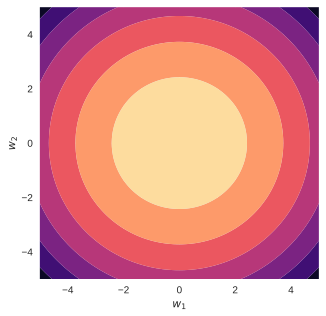

In [188]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, log_prior, cmap='magma')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [189]:
x1 = np.array([ 1.5,  1.])
x2 = np.array([-1.5,  1.])
x3 = np.array([- .5, -1.])

In [190]:
X = np.vstack((x1, x2, x3))
X.shape

(3, 2)

In [191]:
y1 = 1
y2 = 1
y3 = 0

In [192]:
y = np.stack((y1, y2, y3))
y.shape

(3,)

In [193]:
def log_likelihood(w, x, y):
    # equiv. to negative binary cross entropy
    return np.log(expit(np.dot(w.T, x)*(-1)**(1-y)))

In [194]:
llhs = log_likelihood(w_grid.T, X.T, y)
llhs.shape

(300, 300, 3)

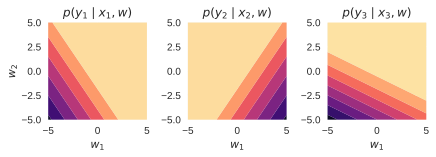

In [195]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 2))
fig.tight_layout()

for i, ax in enumerate(axes):
    
    ax.contourf(w1, w2, llhs[::,::,i], cmap=plt.cm.magma)

    ax.set_xlim(w_min, w_max)
    ax.set_ylim(w_min, w_max)
    
    ax.set_title('$p(y_{{{0}}} \mid x_{{{0}}}, w)$'.format(i+1))
    ax.set_xlabel('$w_1$')    
    
    if not i:
        ax.set_ylabel('$w_2$')

plt.show()

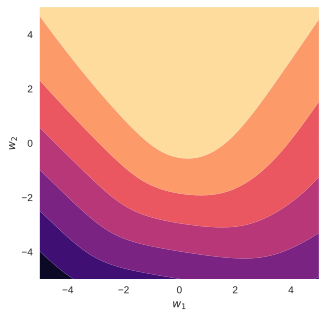

In [196]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, np.sum(llhs, axis=2), 
                cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

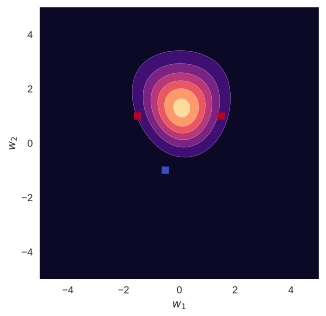

In [197]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, 
            np.exp(log_prior+np.sum(llhs, axis=2)), 
            cmap='magma')

ax.scatter(*X.T, c=y, cmap='coolwarm', marker=',')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

## Model Definitions

### Density Ratio Estimator (Discriminator) Model

$T_{\psi}(x, z)$

Here we consider

$T_{\psi}(w)$

$T_{\psi} : \mathbb{R}^2 \to \mathbb{R}$

In [22]:
discriminator = Sequential(name='discriminator')
discriminator.add(Dense(10, input_dim=LATENT_DIM, activation='relu'))
discriminator.add(Dense(20, activation='relu'))
discriminator.add(Dense(1, activation=None, name='logit'))
discriminator.add(Activation('sigmoid'))
discriminator.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

In [23]:
ratio_estimator = Model(
    inputs=discriminator.inputs, 
    outputs=discriminator.get_layer(name='logit').output)

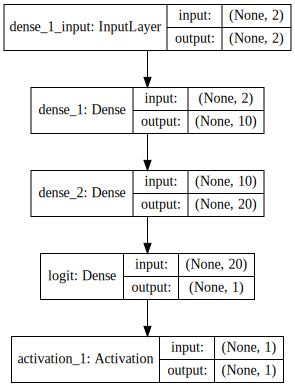

In [24]:
SVG(model_to_dot(discriminator, show_shapes=True)
    .create(prog='dot', format='svg'))

In [25]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

Initial density ratio, prior to any training

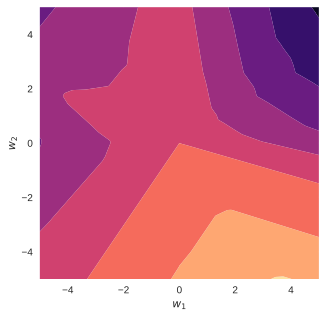

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [27]:
discriminator.evaluate(prior.rvs(size=5), np.zeros(5))

5/5 [==============================] - 0s


[0.63745558261871338, 0.80000001192092896]

### Approximate Inference Model

$z_{\phi}(x, \epsilon)$

Here we only consider

$z_{\phi}(\epsilon)$

$z_{\phi}: \mathbb{R}^3 \to \mathbb{R}^2$

In [28]:
inference = Sequential()
inference.add(Dense(10, input_dim=NOISE_DIM, activation='relu'))
inference.add(Dense(20, activation='relu'))
inference.add(Dense(LATENT_DIM, activation=None))
inference.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


The variational parameters $\phi$ are the trainable weights of the approximate inference model

In [29]:
phi = inference.trainable_weights
phi

[<tf.Variable 'dense_3/kernel:0' shape=(3, 10) dtype=float32_ref>,
 <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'dense_4/kernel:0' shape=(10, 20) dtype=float32_ref>,
 <tf.Variable 'dense_4/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'dense_5/kernel:0' shape=(20, 2) dtype=float32_ref>,
 <tf.Variable 'dense_5/bias:0' shape=(2,) dtype=float32_ref>]

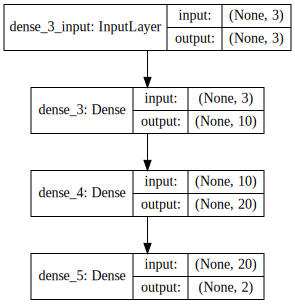

In [30]:
SVG(model_to_dot(inference, show_shapes=True)
    .create(prog='dot', format='svg'))

In [31]:
w_sample_prior = prior.rvs(size=BATCH_SIZE)
w_sample_prior.shape

(128, 2)

In [32]:
eps = np.random.randn(BATCH_SIZE, NOISE_DIM)
w_sample_posterior = inference.predict(eps)
w_sample_posterior.shape

(128, 2)

In [33]:
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

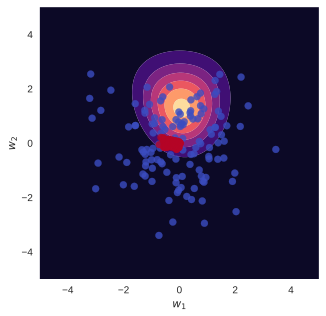

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, 
            np.exp(log_prior+np.sum(llhs, axis=2)), 
            cmap=plt.cm.magma)

ax.scatter(*inputs.T, c=targets, alpha=.8, cmap='coolwarm')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [35]:
metrics = discriminator.evaluate(inputs, targets)

 32/256 [==>...........................] - ETA: 0s

In [36]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

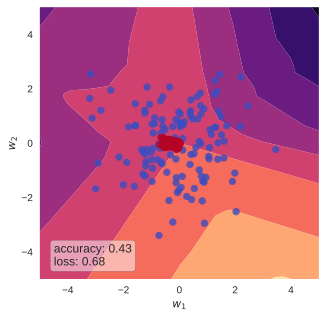

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap='magma')

ax.scatter(*inputs.T, c=targets, alpha=.8, cmap='coolwarm')

train_info = dict(zip(discriminator.metrics_names, metrics))

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

ax.text(0.05, 0.05, 
        ('accuracy: {binary_accuracy:.2f}\n'        
         'loss: {loss:.2f}').format(**train_info), 
        transform=ax.transAxes, bbox=props)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

#### Discriminator pre-training

In [38]:
def train_animate(epoch_num, batch_size=128, steps_per_epoch=20):

    for step in range(steps_per_epoch):

        w_sample_prior = prior.rvs(size=batch_size)

        eps = np.random.randn(batch_size, NOISE_DIM)
        w_sample_posterior = inference.predict(eps)

        inputs = np.vstack((w_sample_prior, w_sample_posterior))
        targets = np.hstack((np.zeros(batch_size), np.ones(batch_size)))

        metrics = discriminator.train_on_batch(inputs, targets)

    ax.cla()

    w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
    w_grid_ratio = w_grid_ratio.reshape(300, 300)

    ax.contourf(w1, w2, w_grid_ratio, cmap='magma')

    ax.scatter(*inputs.T, c=targets, alpha=.8, cmap='coolwarm')

    train_info = dict(zip(discriminator.metrics_names, metrics))
    train_info['epoch'] = epoch_num
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.5)

    ax.text(0.05, 0.05, 
            ('epoch: {epoch:2d}\n'
             'accuracy: {binary_accuracy:.2f}\n'        
             'loss: {loss:.2f}').format(**train_info), 
            transform=ax.transAxes, bbox=props)

    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')

    ax.set_xlim(w_min, w_max)
    ax.set_ylim(w_min, w_max)
    
    return ax

In [39]:
FuncAnimation(fig, train_animate, frames=50, 
              interval=200, # 5 fps
              blit=False)

In [40]:
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

In [41]:
metrics = discriminator.evaluate(inputs, targets)

 32/256 [==>...........................] - ETA: 0s

In [42]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

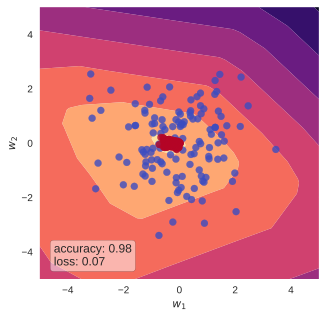

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap='magma')

ax.scatter(*inputs.T, c=targets, alpha=.8, cmap='coolwarm')

train_info = dict(zip(discriminator.metrics_names, metrics))

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

ax.text(0.05, 0.05, 
        ('accuracy: {binary_accuracy:.2f}\n'        
         'loss: {loss:.2f}').format(**train_info), 
        transform=ax.transAxes, bbox=props)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

### Inference Model Training

In [214]:
y_pred = K.sigmoid(K.dot(
    K.constant(w_grid),
    K.transpose(K.constant(X))))
y_pred

<tf.Tensor 'Sigmoid_13:0' shape=(300, 300, 3) dtype=float32>

In [215]:
y_true = K.ones((300, 300, 1))*K.constant(y)
y_true

<tf.Tensor 'mul_50:0' shape=(300, 300, 3) dtype=float32>

In [207]:
llhs_keras = - K.binary_crossentropy(
                   y_pred, 
                   y_true, 
                   from_logits=False)

In [208]:
sess = K.get_session()

In [209]:
np.sum(llhs, axis=-1)

array([[-20.08, -20.01, -19.94, ...,  -2.72,  -2.69,  -2.66],
       [-20.02, -19.95, -19.88, ...,  -2.68,  -2.64,  -2.61],
       [-19.95, -19.88, -19.81, ...,  -2.63,  -2.6 ,  -2.56],
       ..., 
       [-15.1 , -15.03, -14.96, ...,  -2.55,  -2.52,  -2.49],
       [-15.13, -15.06, -14.99, ...,  -2.59,  -2.56,  -2.53],
       [-15.16, -15.09, -15.02, ...,  -2.64,  -2.61,  -2.58]])

In [210]:
np.allclose(np.sum(llhs, axis=-1),
            sess.run(K.sum(llhs_keras, axis=-1)))

True

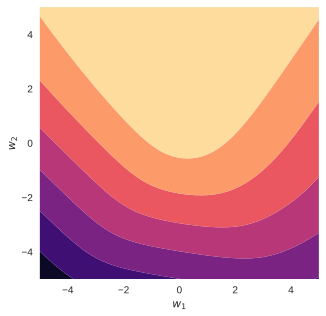

In [211]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, sess.run(K.sum(llhs_keras, axis=-1)), 
            cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [216]:
def make_elbo(ratio_estimator):

    def elbo(y_true, y_pred):
        log_likelihood = - K.binary_crossentropy(y_pred, y_true)
        kl_estimate = K.mean(ratio_estimator(y_pred), axis=-1)
        return log_likelihood - kl_estimate
    
    return elbo

In [217]:
elbo = make_elbo(ratio_estimator)